# Cosmic Ladder at low redshifts: 
# The Local Hubble Parameter Exstime


In [580]:
#************************#
# OBJECTIVE OF THE CODE: #
#************************#
'''
The objective of this code is to partially reproduce the analysis pipiline of the paper 
"A Comprehensive Measurement of the Local Value of the Hubble Constant with 1 km s-1 Mpc-1 
Uncertainty from the Hubble Space Telescope and the SH0ES Team" by Adam G. Riess et al., 18 July 2022, 
archived in https://arxiv.org/pdf/2112.04510.pdf.

The idea is to estimate the Hubble Constant (H0) calibrating the so called Cosmic Distance Ladder, which consists in a
sequence of distance indicators that are calibrated with each other. The final goal is to estimate the
Hubble Constant with a precision of 1 km/s/Mpc.

The code is divided in the following steps:
1. Importing the data:
    - y array: 
        - 2150 magnitudes of Cepheid in SN Ia host galaxies
        - 443 magnitudes of Cepheid minus the distance modulus of the host galaxy, i.e. NGC 4258 (1st anchor)
        - 55 magnitudes of Cepheid in the Andromeda host galaxy, i.e. M31 (2nd anchor)
        - 70 magnitudes of Cepheid minus the distance modulus of the host galaxy, i.e. Large Magellanic Cloud (LMC) (3rd anchor)
        (**WARNING**: in the covariance matrix C in allc file, 482 data are used combining LMC and SMC, i.e. Small Magellanic Cloud; 
        270 + 70 are from LMC and 145 are from SMC, even if 3 of them are not used in the analysis)
        - 42 magnitudes of SN Ia in 37 Cepheid host galaxies (**WARNING**: 77 datasets used)
        - absolute magnitude as measured by HST (Huble Space Telescope), i.e. 1st external constraint
        - absolute magnitude as measured by Gaia, i.e. 2nd external constraint
        - -0.215, i.e. 3rd external constraint on the metallicity
        - 0, i.e. 4th identically zero parameter
        - 0, i.e. 5rd external constraint on the zero point for calibration of LMC Cepheids luminosities
        - 0, i.e. 6th external constraint on bw, slope of the period-luminosity relation
        - 0, i.e. 7th external constraint on the difference between measured and true distance for NGC 4258
        - 0, i.e. 8th external constraint on the difference between measured and true distance for LMC
        - 277 magnitudes of SN Ia minus the logaritmic expression in the article minus 25
    - L matrix:
        - 2150 equations for period P and metallicity of Cepheid in SN Ia host galaxies
        - 443 equations for period P and metallicity of Cepheid in NGC 4258
        - 55 equations for period P and metallicity of Cepheid in M31
        - 482 equations for period P and metallicity of Cepheid in LMC
        - 42 equations for magnitudes of SN Ia in 37 Cepheid host galaxies (WARNING: 77 datasets used)
        - 1 equation for the absolute magnitude as measured by HST
        - 1 equation for the absolute magnitude as measured by Gaia
        - 1 equation for the zero point for calibration of LMC Cepheids luminosities
        - 1 equation for the difference between measured and true distance for NGC 4258
        - 1 equation for the difference between measured and true distance for LMC
        - 277 equations for magnitudes of SN Ia in 37 Cepheid host galaxies
    - C matrix: for which formalism, please go to the article Section 2.1

2. Plotting the Covariace Matrix C as in Figure 11 of the article

3. Hubble Constant estimation using the least squares method, analitically derived, with the following steps:
    - Step 1:
    Calculating the inverce covariance matrix C^-1
    - Step2:
    Calculating the matrix A = L^T C^-1 L
    - Step 3:
    Calculating the matrix B = L^T C^-1 y
    - Step 4:
    Calculating the matrix Q_best = A^-1 B
    - Step 5:
    Calculating the parameter covariance matrix C_Q = A^-1
    - Step 6:
    Writing the results
    - Step 7:
    H0 in all its glory

4. Hubble Constant estimation using the least squares method, with scipy library:
    - Step 1:
    Calculating the inverse covariance matrix C^-1
    - Step 2:
    Defining the chi2 statistic
    - Step 3:
    Fitting using the scipy.optimize.minimize method
    - Step 4:
    Calculating the parameter covariance matrix C_Q_py = A^-1
    - Step 5:
    Writing the results
    - Step 6:
    H0_fit in all its glory

5. Plots of the single rungs: 
    - 1st rung:
    Only 3 anchors, no Milky Way Cepheids data available
    - 2nd rung:
    all 77 data sets instead of only the 42 recorded events
    - 3rd rung:
    Only the 277 calibration points used in the article (red points of figure 12 of the article, no black points)

6. Supreme Hubble Plot as similar as possible to figure 12 of the article

7. Hubble Plot with also attempt of Linear Regrassion with all data   
'''

'\nThe objective of this code is to partially reproduce the analysis pipiline of the paper \n"A Comprehensive Measurement of the Local Value of the Hubble Constant with 1 km s-1 Mpc-1 \nUncertainty from the Hubble Space Telescope and the SH0ES Team" by Adam G. Riess et al., 18 July 2022, \narchived in https://arxiv.org/pdf/2112.04510.pdf.\n\nThe idea is to estimate the Hubble Constant (H0) calibrating the so called Cosmic Distance Ladder, which consists in a\nsequence of distance indicators that are calibrated with each other. The final goal is to estimate the\nHubble Constant with a precision of 1 km/s/Mpc.\n\nThe code is divided in the following steps:\n1. Importing the data:\n    - y array: \n        - 2150 magnitudes of Cepheid in SN Ia host galaxies\n        - 443 magnitudes of Cepheid minus the distance modulus of the host galaxy, i.e. NGC 4258 (1st anchor)\n        - 55 magnitudes of Cepheid in the Andromeda host galaxy, i.e. M31 (2nd anchor)\n        - 70 magnitudes of Cepheid 

In [581]:
#****************#
# USEFUL IMPORTS #
#****************#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from astropy.io import fits
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

In [582]:
#*************************#
# DATA IMPORT .fits FILES #
#*************************#

# Opening .fits files

# Opening ally
file_path = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/ally_shoes_ceph_topantheonwt6.0_112221.fits'
with fits.open(file_path) as hdul:
    hdul.info()  # Show information about the content of the file
    # Read the data
    y = hdul[0].data

# Opening alll
file_path1 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/alll_shoes_ceph_topantheonwt6.0_112221.fits'
with fits.open(file_path1) as hdul:
    hdul.info()  # Show information about the content of the file
    # Read the data
    L = hdul[0].data

# Opening allc
file_path2 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/allc_shoes_ceph_topantheonwt6.0_112221.fits'
with fits.open(file_path2) as hdul:
    hdul.info()  # Show information about the content of the file
    # Read the data
    C = hdul[0].data

# Printing y in a .dat file to check it
output_path = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/y.dat'
np.savetxt(output_path, y, fmt='%f')

# Printing L in a .dat file to check it
output_path1 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/L.dat'
np.savetxt(output_path1, L, fmt='%f')

# Printing C in a .dat file to check it
# **WARNING**: the file is too big to be pushed on git
#output_path2 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/C.dat'
#np.savetxt(output_path2, C, fmt='%f')

Filename: /home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/ally_shoes_ceph_topantheonwt6.0_112221.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (3492,)   float32   
Filename: /home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/alll_shoes_ceph_topantheonwt6.0_112221.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (3492, 47)   float32   
Filename: /home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/allc_shoes_ceph_topantheonwt6.0_112221.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (3492, 3492)   float32   


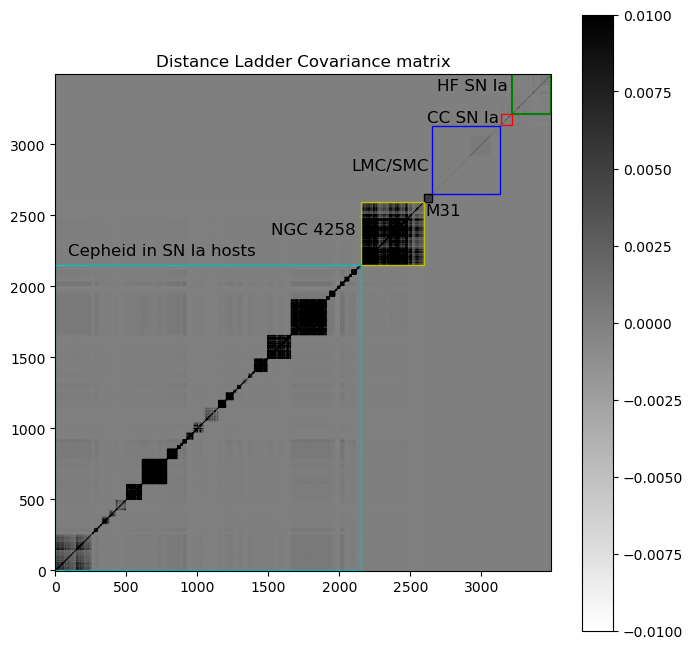

In [583]:
# Visualizing the Covariance with matplotlib
# OBS.: the color code has been selected to be in agreement with the article plot

plt.figure(figsize=(8, 8))
# Setting minimum and maximum values for the colormap
min = -0.01
max = 0.01
# Plotting the Covariance matrix
plt.imshow(C, cmap='gray_r', vmin=min, vmax=max, origin='lower') 
# **WARNING**: the origin='lower' is used to have the same orientation as in the article plot, but it gives
# the diagonal with respect to the matematical definition of the matrix flipped upside down
plt.colorbar()
plt.title('Distance Ladder Covariance matrix')

# Adding squares to highlight the different blocks of the matrix

# SN Ia in the Hubble Flow
x_hf = 3215
y_hf = 3215
size_hf = 277
square_hf = plt.Rectangle((x_hf, y_hf), size_hf, size_hf, edgecolor='g', facecolor='none', linewidth=1.5)
plt.gca().add_patch(square_hf)
label_text_hf = 'HF SN Ia'
plt.text(x_hf - size_hf, y_hf + 200 , label_text_hf, color='k', ha='center', va='center', fontsize=12)

# SN Ia in Cepheid Host Galaxies (42 SN Ia, but 77 datasets)
x_cc = 3138
y_cc = 3138
size_cc = 77
square_cc = plt.Rectangle((x_cc, y_cc), size_cc, size_cc, edgecolor='r', facecolor='none', linewidth=1.)
plt.gca().add_patch(square_cc)
label_text_cc = 'CC SN Ia'
plt.text(x_cc - 3.5*size_cc, y_cc + 50, label_text_cc, color='k', ha='center', va='center', fontsize=12)

# External Constraints
# Space of 8 * 8 elements due to external constraints

# LMC and SMC
x_lmc = 2649
y_lmc = 2649
size_lmc = 482
square_lmc = plt.Rectangle((x_lmc, y_lmc), size_lmc, size_lmc, edgecolor='b', facecolor='none', linewidth=1.)
plt.gca().add_patch(square_lmc)
label_text_lmc = 'LMC/SMC'
plt.text(x_lmc - 0.6*size_lmc, y_lmc + 200, label_text_lmc, color='k', ha='center', va='center', fontsize=12)

# M31
x_m31 = 2594
y_m31 = 2594
size_m31 = 55
square_m31 = plt.Rectangle((x_m31, y_m31), size_m31, size_m31, edgecolor='k', facecolor='none', linewidth=1.)
plt.gca().add_patch(square_m31)
label_text_m31 = 'M31'
plt.text(x_m31 + 2.5*size_m31, y_m31 - 60, label_text_m31, color='k', ha='center', va='center', fontsize=12)

# NGC 4258
x_ngc = 2151
y_ngc = 2151
size_ngc = 443
square_ngc = plt.Rectangle((x_ngc, y_ngc), size_ngc, size_ngc, edgecolor='y', facecolor='none', linewidth=1.)
plt.gca().add_patch(square_ngc)
label_text_ngc = 'NGC 4258'
plt.text(x_ngc - 0.75*size_ngc, y_ngc + 250, label_text_ngc, color='k', ha='center', va='center', fontsize=12)

# Cepheid in SN Ia Host Galaxies
x_ceph = 0.
y_ceph = 0.
size_ceph = 2150
square_ceph = plt.Rectangle((x_ceph, y_ceph), size_ceph, size_ceph, edgecolor='c', facecolor='none', linewidth=1.)
plt.gca().add_patch(square_ceph)
label_text_ceph = 'Cepheid in SN Ia hosts'
plt.text(x_ceph + 0.35*size_ceph, y_ceph + 2250, label_text_ceph, color='k', ha='center', va='center', fontsize=12)



plt.show()

In [584]:
#*************************************#
# DATA ANALYSIS: LEAST SQUARES METHOD #
# (ANALITICALLY DERIVED)              #
#*************************************#

# Step 1: 
# Calculating the inverse covariance matrix C^-1

C_inv = np.linalg.inv(C)

In [585]:
# Step 2:
# Calculating the matrix A = L^T C^-1 L

# Preparing L and y for the matrix multiplication
L_fit = np.transpose(L)
print('Matrix L shape:', L.shape)
print('Matrix L_fit shape:', L_fit.shape)

y_fit = np.transpose(y)
print('Matrix y shape:', y.shape)
print('Matrix y_fit shape:', y_fit.shape)

A = np.dot(np.dot(L_fit.T, C_inv), L_fit) 
print('Matrix A shape:', A.shape)

Matrix L shape: (47, 3492)
Matrix L_fit shape: (3492, 47)
Matrix y shape: (3492,)
Matrix y_fit shape: (3492,)
Matrix A shape: (47, 47)


In [586]:
# Step 3:
# Calculating the matrix B = L^T C^-1 y

B = np.dot(np.dot(L_fit.T, C_inv), y_fit)
print('Matrix B shape:', B.shape)

Matrix B shape: (47,)


In [587]:
# Step 4:
# Calculating the matrix Q_best = A^-1 B

Q_best = np.linalg.solve(A, B)
print('Matrix Q_best shape:', Q_best.shape)

Matrix Q_best shape: (47,)


In [588]:
# Step 5:
# Calculating the parameter covariance matrix C_Q = A^-1

C_Q = np.linalg.inv(A)
print('Matrix C_Q shape:', C_Q.shape)

Matrix C_Q shape: (47, 47)


In [589]:
# Step 6:
# Writing the results on lstsq_analytically.dat

output_path3 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/lstsq_analytically.dat'

# Writing the results on the file
with open(output_path3, 'w') as f:
    f.write('The first 37 parameters are the distance moduli of the Cepheid host galaxies.\n')
    f.write('Printed with theire errors, they are:\n')
    for i in range(37):
        f.write('Distance modulus of Cepheid host galaxy ' + str(i+1) + ': ' + str(Q_best[i]) + ' +/- ' + str(np.sqrt(C_Q[i, i])) + ' mag\n')
    f.write('\n')
    f.write('The 38th parameter is $\Delta \mu_{N4258}$: ' + str(Q_best[37]) + ' +/- ' + str(np.sqrt(C_Q[37, 37])) + ' mag\n')
    f.write('\n')
    f.write('The 39th parameter is the reference Cepheids magnitudes: ' + str(Q_best[38]) + ' +/- ' + str(np.sqrt(C_Q[38, 38])) + ' mag\n')
    f.write('\n')
    f.write('The 40th parameter is $\Delta \mu_{LMC}$: ' + str(Q_best[39]) + ' +/- ' + str(np.sqrt(C_Q[39, 39])) + ' mag\n')
    f.write('\n')
    f.write('The 41st parameter is $\Delta \mu_{M31}$: ' + str(Q_best[40]) + ' +/- ' + str(np.sqrt(C_Q[40, 40])) + ' mag\n')
    f.write('\n')
    f.write('The 42nd parameter, adding -3.285, gives bw: ' + str(Q_best[41]-3.285) + ' +/- ' + str(np.sqrt(C_Q[41, 41])) + ' mag\n')
    f.write('\n')
    f.write('The 43rd parameter is the reference magnitude for SN Ia: ' + str(Q_best[42]) + ' +/- ' + str(np.sqrt(C_Q[42, 42])) + ' mag\n')
    f.write('\n')
    f.write('The 44th parameter is Zw: ' + str(Q_best[43]) + ' +/- ' + str(np.sqrt(C_Q[43, 43])) + ' mag/dex\n')
    f.write('\n')
    f.write('The 45th parameter is identically 0: ' + str(Q_best[44]) + ' +/- ' + str(np.sqrt(C_Q[44, 44])) + '\n')
    f.write('\n')
    f.write('The 46th parameter is identically $\Delta zp$: ' + str(Q_best[45]) + ' +/- ' + str(np.sqrt(C_Q[45, 45])) + ' mag\n')
    f.write('\n')
    f.write('The 47th parameter is 5log(H0): ' + str(Q_best[46]) + ' +/- ' + str(np.sqrt(C_Q[46, 46])))



In [590]:
# Step 7:
# H0 in all its glory

H0_fit = Q_best[46]
eH0_fit = np.sqrt(C_Q[46, 46])

H0  = 10**(H0_fit/5)
eH0 = 0.2 * 10**(H0_fit/5) *np.log(10)*  eH0_fit 
print('H0:', H0, '+/-', eH0, 'km s^-1 Mpc^-1')

H0: 73.04107586628558 +/- 1.007124654063262 km s^-1 Mpc^-1


In [591]:
#*************************************#
# DATA ANALYSIS: LEAST SQUARES METHOD #
# (USING SCIPY LIBRARY)               #
#*************************************#

# Step 1: 
# Calculating the inverse covariance matrix C^-1
# C_inv = np.linalg.inv(C)


In [592]:
# Step 2: 
# Defining the chi2 statistic
def chi2(Q):
    diff = y_fit - np.dot(L_fit, Q)
    chi2 = np.dot(diff.T, np.dot(C_inv, diff))
    return chi2

In [593]:
# Step 3: 
# Fitting using the scipy.optimize.minimize method
# **WARNING**: fixing Q0 as a 0 vector implies a resolution time of around 20 minutes
# Q0 = np.zeros(L.shape[0])
# Setting Q0 as the best fit from the analytically derived method implies a resolution time of less than 10 seconds
Q0 = Q_best
result_py = minimize(chi2, Q0, options={'disp': True})
Q_best_py = result_py.x

         Current function value: 3552.759277
         Iterations: 1
         Function evaluations: 3245
         Gradient evaluations: 66


/home/git/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [594]:
# Step 4:
# Calculating the parameter covariance matrix C_Q_py = A^-1

C_Q_py = np.linalg.inv(A)
print('Matrix C_Q_py shape:', C_Q_py.shape)

Matrix C_Q_py shape: (47, 47)


In [595]:
# Step 5:
# Writing the results on lstsq_scipy.dat

output_path4 = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/lstsq_scipy.dat'

# Writing the results on the file

with open(output_path4, 'w') as f:
    f.write('The first 37 parameters are the distance moduli of the Cepheid host galaxies.\n')
    f.write('Printed with theire errors, they are:\n')
    for i in range(37):
        f.write('Distance modulus of Cepheid host galaxy ' + str(i+1) + ': ' + str(Q_best_py[i]) + ' +/- ' + str(np.sqrt(C_Q_py[i, i])) + ' mag\n')
    f.write('\n')
    f.write('The 38th parameter is $\Delta \mu_{N4258}$: ' + str(Q_best_py[37]) + ' +/- ' + str(np.sqrt(C_Q_py[37, 37])) + ' mag\n')
    f.write('\n')
    f.write('The 39th parameter is the reference Cepheids magnitudes: ' + str(Q_best_py[38]) + ' +/- ' + str(np.sqrt(C_Q_py[38, 38])) + ' mag\n')
    f.write('\n')
    f.write('The 40th parameter is $\Delta \mu_{LMC}$: ' + str(Q_best_py[39]) + ' +/- ' + str(np.sqrt(C_Q_py[39, 39])) + ' mag\n')
    f.write('\n')
    f.write('The 41st parameter is $\Delta \mu_{M31}$: ' + str(Q_best_py[40]) + ' +/- ' + str(np.sqrt(C_Q_py[40, 40])) + ' mag\n')
    f.write('\n')
    f.write('The 42nd parameter, adding -3.285, gives bw: ' + str(Q_best_py[41]-3.285) + ' +/- ' + str(np.sqrt(C_Q_py[41, 41])) + ' mag\n')
    f.write('\n')
    f.write('The 43rd parameter is the reference magnitude for SN Ia: ' + str(Q_best_py[42]) + ' +/- ' + str(np.sqrt(C_Q_py[42, 42])) + ' mag\n')
    f.write('\n')
    f.write('The 44th parameter is Zw: ' + str(Q_best_py[43]) + ' +/- ' + str(np.sqrt(C_Q_py[43, 43])) + ' mag/dex\n')
    f.write('\n')
    f.write('The 45th parameter is identically 0: ' + str(Q_best_py[44]) + ' +/- ' + str(np.sqrt(C_Q_py[44, 44])) + '\n') 
    f.write('\n')
    f.write('The 46th parameter is identically $\Delta zp$: ' + str(Q_best_py[45]) + ' +/- ' + str(np.sqrt(C_Q_py[45, 45])) + ' mag\n')
    f.write('\n')
    f.write('The 47th parameter is 5log(H0): ' + str(Q_best_py[46]) + ' +/- ' + str(np.sqrt(C_Q_py[46, 46])))
    f.write('\n')

In [596]:
# Step 6:
# H0_fit in all its glory

H0_fit_py = Q_best_py[46]
eH0_fit_py = np.sqrt(C_Q_py[46, 46])

H0_py  = 10**(H0_fit_py/5)
eH0_py = 0.2 * 10**(H0_fit_py/5) *np.log(10)*  eH0_fit_py

print('H0_py:', H0_py, '+/-', eH0_py, 'km s^-1 Mpc^-1')

H0_py: 73.0410756567058 +/- 1.0071246511734775 km s^-1 Mpc^-1


In [597]:
# Checking chi2/NDF

chi2_best = chi2(Q_best)
NDF = 3445
chi2_best_NDF = chi2_best / NDF
print('Chi^2/NDF:', chi2_best_NDF)
print('The obtained value is in full agreement with the article one.')

Chi^2/NDF: 1.031279977208817
The obtained value is in full agreement with the article one.


In [598]:
#**********************#
# PLOTTING THE RESULTS #
#**********************#

# 1st rung: Cepheids in anchor galaxies (NGC 4258, LMC, M31)

mu_M31 = Q_best[40] # obtained from lstsq method
e_mu_M31 = np.sqrt(C_Q[40, 40]) # obtained from lstsq method

mu_LMC = 18.477 # obtained from the article
e_mu_LMC = 0.0263 # obtained from the article

mu_NGC4258 = 29.397 # obtained from the article "Absolute Calibration of Cepheid Period-Luminosity Relations in NGC 4258", 
                    # Wenlong Yuan et al., 2022, https://arxiv.org/pdf/2203.06681.pdf
e_mu_NGC4258 = 0.032 # obtained from the article "Absolute Calibration of Cepheid Period-Luminosity Relations in NGC 4258",
                    # Wenlong Yuan et al., 2022, https://arxiv.org/pdf/2203.06681.pdf

M = Q_best[38] # obtained from lstsq method, reference Cepheids magnitude
eM = np.sqrt(C_Q[38, 38]) # obtained from lstsq method, reference Cepheids magnitude error

mM_M31 = np.sum(y[2593:2648]-M)/55 # magnitude mean on the Cepheids with respect to reference 
emM_M31 = np.sqrt(np.sum(np.diag(C)[2593:2648]))/55 # magnitude error mean on the Cepheids with respect to reference
print('mM_M31:', mM_M31)
print('emM_M31:', emM_M31)

mM_LMC = np.sum(y[2649:3131]+mu_LMC-M)/482 # magnitude mean on the Cepheids with respect to reference
emM_LMC = np.sqrt(np.sum(np.diag(C)[2649:3131] + e_mu_LMC**2)) / 482 # magnitude error mean on the Cepheids 
                                                                     # with respect to reference and with propagated error
print('mM_LMC:', mM_LMC)
print('emM_LMC:', emM_LMC)

mM_NGC4258 = np.sum(y[2151:2593]+mu_NGC4258-M)/443 # magnitude mean on the Cepheids with respect to reference
emM_NGC4258 = np.sqrt(np.sum(np.diag(C)[2151:2593] + e_mu_NGC4258**2)) / 443 # magnitude error mean on the Cepheids 
                                                                             # with respect to reference and with propagated error
print('mM_NGC4258:', mM_NGC4258)
print('emM_NGC4258:', emM_NGC4258)

# Defining the 3 points of the 1st rung as tuples
points_rung1 = [(mu_LMC, mM_LMC), (mu_M31, mM_M31), (mu_NGC4258, mM_NGC4258)]
error_rung1 = [(e_mu_LMC, emM_LMC), (e_mu_M31, emM_M31), (e_mu_NGC4258, emM_NGC4258)]

mM_M31: 24.418392666903408
emM_M31: 0.018441865660927512
mM_LMC: 18.54857284102697
emM_LMC: 0.004944219134160592
mM_NGC4258: 29.386116940603838
emM_NGC4258: 0.023438539784864165


Coefficient: [0.9925457]
Intercept: 0.21540818454195687, mag


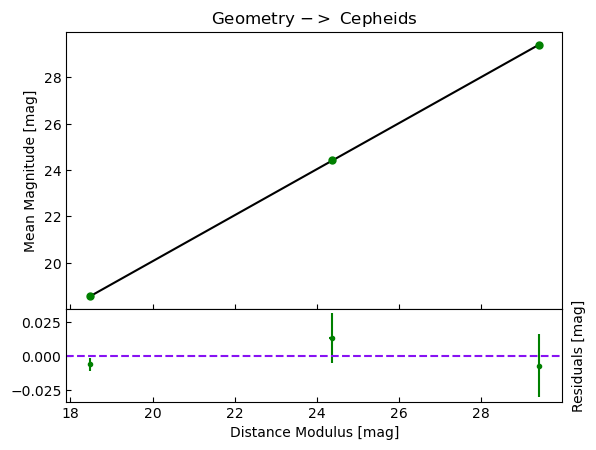

In [599]:
# 1st rung plot
# Ebstracting data for plot and linear regression
mu_anc_values = np.array([x[0] for x in points_rung1])
mu_anc_values_fit = np.array([x[0] for x in points_rung1]).reshape(-1, 1)
mM_anc_values = np.array([x[1] for x in points_rung1])
mu_anc_errors = np.array([x[0] for x in error_rung1])
mM_anc_errors = np.array([x[1] for x in error_rung1])

# Linear regression
model = LinearRegression()
model.fit(mu_anc_values_fit, mM_anc_values)
mM_anc_pred = model.predict(mu_anc_values_fit)

# Residual calculation
residuals = mM_anc_values - mM_anc_pred

# 1st rung plot + residuals with GridSpec
fig = plt.figure()
gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# Main Plot
ax0 = plt.subplot(gs[0])
ax0.errorbar(mu_anc_values, mM_anc_values, xerr=mu_anc_errors, yerr=mM_anc_errors, fmt='o', color='g', markersize=5)
ax0.plot(mu_anc_values, mM_anc_pred, color='k')
ax0.set_ylabel('Mean Magnitude [mag]')
ax0.set_title(r'Geometry $->$ Cepheids')

# Residual Plot
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.errorbar(mu_anc_values, residuals, xerr=mu_anc_errors, yerr=mM_anc_errors, fmt='o', color='g', markersize=3)
ax1.axhline(0, color='#8712F3', linestyle='--')
ax1.set_ylabel('Residuals [mag]', labelpad=-415)
ax1.set_xlabel('Distance Modulus [mag]')

# Adapting labels and ticks
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.tick_params(axis='x', direction='in')
ax0.tick_params(axis='y', direction='in')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in')

# Parameters
coefficient_1 = model.coef_
intercept_1 = model.intercept_

# Print parameters
print(f"Coefficient: {coefficient_1}")
print(f"Intercept: {intercept_1}, mag")

plt.show()

In [600]:
# 2nd rung: SN Ia in Cepheid host galaxies

M_SN = Q_best[42] # obtained from lstsq method, reference magnitude for SN Ia
eM_SN2 = C_Q[42, 42] # obtained from lstsq method, reference magnitude for SN Ia error

# Magnitudes of the SN Ia with respect to the reference magnitude
mM_SN_IA = y[3130:3206] - M_SN
emM_SN_IA = np.sqrt(np.diag(C)[3130:3206]) + eM_SN2

# Magnitudes of the hosts galaxies
matrix = L_fit[3130:3206, 0:37] * Q_best[0:37]
mu_host_SN_IA = matrix[matrix != 0]

# Taking the index of the non 0 element for each column
indices = np.argmax(matrix != 0, axis=1)

# Defining the errors for magnitudes hosts
extracted_errors = np.sqrt(C_Q[indices, indices])

Coefficient: [1.0181978]
Intercept: -0.5957832336425781


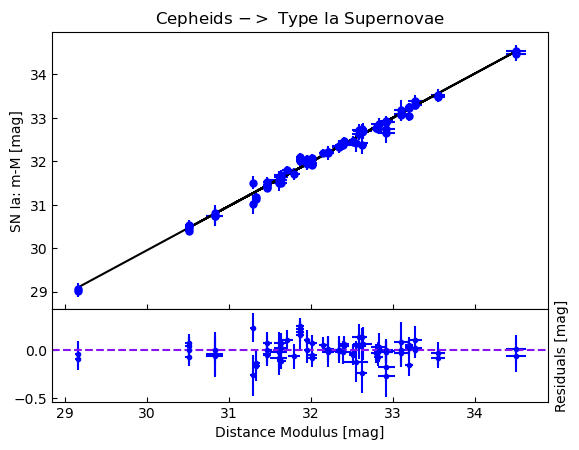

In [601]:
# 2nd rung plot

# Linear regression
model = LinearRegression()
model.fit(mu_host_SN_IA.reshape(-1, 1), mM_SN_IA)
mM_SN_pred = model.predict(mu_host_SN_IA.reshape(-1, 1))

# Residual calculation
residuals_SN = mM_SN_IA - mM_SN_pred

# 2nd rung plot + residuals with GridSpec
fig = plt.figure()
gs_SN = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# Main Plot
ax0 = plt.subplot(gs_SN[0])
ax0.errorbar(mu_host_SN_IA, mM_SN_IA, xerr=extracted_errors, yerr=emM_SN_IA, fmt='o', color='b', markersize=5)
ax0.plot(mu_host_SN_IA, mM_SN_pred, color='k')
ax0.set_ylabel(r'SN Ia: m-M [mag]')
ax0.set_title(r'Cepheids $->$ Type Ia Supernovae')

# Residual Plot
ax1 = plt.subplot(gs_SN[1], sharex=ax0)
ax1.errorbar(mu_host_SN_IA, residuals_SN, xerr=extracted_errors, yerr=emM_SN_IA, fmt='o', color='b', markersize=3)
ax1.axhline(0, color='#8712F3', linestyle='--')
ax1.set_ylabel('Residuals [mag]', labelpad=-400)
ax1.set_xlabel('Distance Modulus [mag]')

# Adapting labels and ticks
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.tick_params(axis='x', direction='in')
ax0.tick_params(axis='y', direction='in')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in')

# Parameters
coefficient_2 = model.coef_
intercept_2 = model.intercept_

# Print parameters
print(f"Coefficient: {coefficient_2}")
print(f"Intercept: {intercept_2}")

plt.show()





In [602]:
# 3rd rung: SN Ia in the Hubble Flow 

# SN Ia in the Hubble Flow
# Obtaining redshifts data
# **WARNING**: this file, obtained from the git repository of the article, IS NOT in folder SHOES_Data, 
# but in folder Pantheon+_Data/4_DISTANCES_AND_COVAR

# Reading with pandas
file_path_z = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/Pantheon+SH0ES.dat'
df = pd.read_csv(file_path_z, sep=' ')

In [603]:
# Printing the first few lines of the file to have a catch at its structure
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [604]:
# Extracting the redshifts and their errors used for the Hubble plot
z     = df['zHD']
z_err = df['zHDERR']

In [605]:
# Appling filtering condition, keeping only Hubble Flow SN Ia
'''
nomi_specifici= ['000006', '000011', '000034', '000091',
'000142', '000190','000199', '000215', '000236', '000420',
'010026', '020027', '020096', '020176', '030066', '040137',
'040166', '040782', '050005', '050203', '050251', '050293',
'050301', '050607', '070955', '080723', '090201', '091869',
'100090', '100163', '100213', '100405', '110033', '110478',
'110536', '110567', '110719', '110734', '120085', '120094',
'120336', '120400', '120585', '130308', '130514', '130862',
'140181', '150509', '151034', '160039', '160099', '160197',
'160200', '170428', '180166', '180561', '190230', '190260',
'300105', '310025', '310042', '310073', '310091', '310161',
'310238', '310574', '320258', '330022', '330089', '330128',
'340146', '340334', '350047', '350078', '350083', '350233',
'350316', '350548', '360112', '360140', '360156', '370098',
'370308', '370333', '370356', '370369', '370428', '370563',
'380279', '380378', '390264', '390471', '420100', '420159',
'420258', '420407', '420417', '430004', '440008', '440042',
'440162', '440509', '450175', '460003', '460037', '460105',
'470008', '470041', '470232', '470244', '480064', '480464',
'490008', '490521', '500004', '500057', '500100', '500504',
'510251', '510457', '510578', '510638', '520019', '520023',
'520062', '520077', '520188', '530112', '530219', '540163',
'550041', '550096', '550154', '550218', '560087', '560121',
'560152', '570025', '570062', '580235', '580275', '580300',
'590005', '200132', '350180', '000010', '000014', '000038',
'000137', '000174', '000196', '000202', '000220', '010010',
'020090', '030006', '040150', '040201', '040780', '050003',
'050201', '050291', '050296', '050303', '050580', '070242',
'080064', '080646', '090037', '090275', '100101', '100206',
'100358', '110425', '110430', '110460', '110484', '110542',
'110716', '110721', '120044', '120086', '120143', '120369',
'120444', '120586', '130755', '140152', '150254', '150457',
'160070', '160126', '160198', '160214', '170078', '180313',
'190209', '190340', '300179', '310039', '310051', '310090',
'310146', '310188', '310260', '320099', '320469', '330023',
'330083', '330106', '340229', '350027', '350050', '350080',
'350192', '350235', '350374', '350630', '360139', '360145',
'370066', '370329', '370344', '370367', '370394', '370498',
'370566', '370595', '380318', '390259', '390449', '390627',
'420196', '420352', '420414', '430003', '440005', '440050',
'440236', '440285', '440643', '450082', '450339', '460064',
'470015', '470043', '470110', '480184', '490007', '490037',
'500038', '500065', '500301', '500511', '510113', '510266',
'510550', '510597', '520022', '520041', '520071', '530037',
'530086', '530251', '550005', '550059', '550137', '550155',
'550202', '560027', '560054', '560150', '570022', '570056',
'580104', '580270', '580276', '580312', '590031', '590194',
'520016', '380199']

condition = (df['REDSHIFT_CMB'].between(0.0233,0.15, inclusive='neither')) & (df['CID'].isin(nomi_specifici))
#condition = (df['REDSHIFT_CMB'].between(0.0233,0.56, inclusive='neither')) & (df['CID'].isin(nomi_specifici))
'''
df_filtered = df[df['USED_IN_SH0ES_HF'] == 1]
df_result = df_filtered[['zHD', 'zHDERR']]
print('Two columns (z and treir error) and 277 samples are expected.\nThis is confermed by the shape of the data storage:', df_result.shape)

Two columns (z and treir error) and 277 samples are expected.
This is confermed by the shape of the data storage: (277, 2)


In [606]:
# Defining a useful constant, light speed in km/s
c = 299792.458
# Taking values for q0 and j0
q0 = -0.55
j0 = 1.0

# Definng the graph points

# Calculating the expanded logarithmic expression
fiveloga = 5*np.log10(df_result['zHD']*c*(1+0.5*(1-q0)*df_result['zHD']-1/6*(1-q0-3*q0**2+j0)*df_result['zHD']**2))

# Computing SN Ia m-M from data
mM_hf = y[3215:3492] + fiveloga + 25 - M_SN 
emM_hf = np.sqrt(np.diag(C)[3215:3492] + eM_SN2**2) # error propagation using covariance matrix

# Computing mu SN Ia from data and fit
mu_hf = fiveloga - Q_best[46] + 25
e_mu_hf = np.sqrt(np.diag(C)[3215:3492] + eH0_fit**2)



Coefficient: [1.00319708]
Intercept: -0.11741764240804287, mag


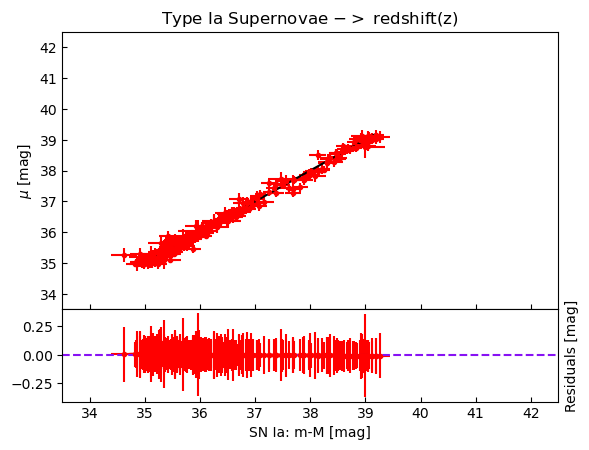

In [607]:
# 3rd rung plot

# Linear regression
model = LinearRegression()
model.fit(mu_hf.values.reshape(-1, 1), mM_hf)
mu_hf_pred = model.predict(mu_hf.values.reshape(-1, 1))

# Residual calculation
residuals_hf = mu_hf - mu_hf_pred

# 3rd rung plot + residuals with GridSpec
fig = plt.figure()
gs_hf = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# Main Plot
ax0 = plt.subplot(gs_hf[0])
ax0.errorbar(mM_hf, mu_hf, xerr=emM_hf, yerr=e_mu_hf, fmt='o', color='r', markersize=3)
ax0.plot(mu_hf, mu_hf_pred, color='k')
ax0.set_ylabel(r'$\mu$ [mag]')
ax0.set_ylim(33.5, 42.5)
ax0.set_xlim(33.5, 42.5)
ax0.set_title(r'Type Ia Supernovae $->$ redshift(z)')


# Residual Plot
ax1 = plt.subplot(gs_hf[1], sharex=ax0)
ax1.errorbar(mM_hf, residuals_hf, xerr=emM_hf, yerr=e_mu_hf, fmt='o', color='r', markersize=3)
ax1.axhline(0, color='#8712F3', linestyle='--')
ax1.set_xlim(33.5, 42.5)
ax1.set_ylabel('Residuals [mag]', labelpad=-410)
ax1.set_xlabel(r'SN Ia: m-M [mag]')


# Adapting labels and ticks
ax0.tick_params(axis='x', direction='in')
ax0.tick_params(axis='y', direction='in')
ax1.tick_params(axis='x', direction='in')

# Parameters
coefficient_3 = model.coef_
intercept_3 = model.intercept_

# Print parameters
print(f"Coefficient: {coefficient_3}")
print(f"Intercept: {intercept_3}, mag")


plt.show()



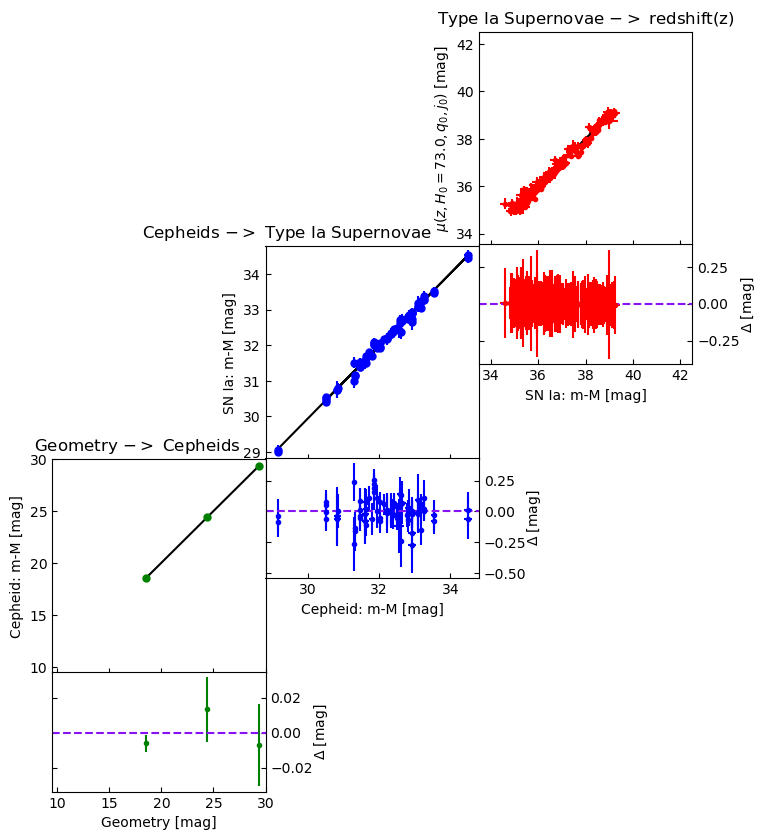

In [608]:
#*********************#
# SUPREME HUBBLE PLOT #
#*********************#  

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, gridspec_kw={'height_ratios': [1.5, 1]})

# Adjusting the subplot parameters to remove space between first and second line of plots
plt.subplots_adjust(hspace=0.0)

# 1st rung
ax1.errorbar(mu_anc_values, mM_anc_values, xerr=mu_anc_errors, yerr=mM_anc_errors, fmt='o', color='g', markersize=5)
ax1.plot(mu_anc_values, mM_anc_pred, color='k')
ax1.set_ylabel(r'Cepheid: m-M [mag]')
ax1.set_ylim(9.5, 30.0)
ax1.set_xlim(9.5, 30.0)
title1 = ax1.set_title(r'Geometry $->$ Cepheids')
title1.set_position([0.4, 1.02]) 

# Residual Plot
ax4.errorbar(mu_anc_values, residuals, xerr=mu_anc_errors, yerr=mM_anc_errors, fmt='o', color='g', markersize=3)
ax4.axhline(0, color='#8712F3', linestyle='--')
ax4.set_xlim(9.5, 30.0)
ax4.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax4.set_xlabel(r'Geometry [mag]')

# Adapting labels and ticks
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in')
ax4.tick_params(axis='x', direction='in')
ax4.tick_params(axis='y', direction='in', labelright=True, right=True)

# 2nd rung
ax2.errorbar(mu_host_SN_IA, mM_SN_IA, xerr=extracted_errors, yerr=emM_SN_IA, fmt='o', color='b', markersize=5)
ax2.plot(mu_host_SN_IA, mM_SN_pred, color='k')
ax2.set_ylim(28.8, 34.8)
ax2.set_xlim(28.8, 34.8)
ax2.set_ylabel(r'SN Ia: m-M [mag]')
title2 = ax2.set_title(r'Cepheids $->$ Type Ia Supernovae')
title2.set_position([0.1, 2.04])

# Residual Plot
ax5.errorbar(mu_host_SN_IA, residuals_SN, xerr=extracted_errors, yerr=emM_SN_IA, fmt='o', color='b', markersize=3)
ax5.axhline(0, color='#8712F3', linestyle='--')
ax5.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax5.set_xlim(28.8, 34.8)
ax5.set_xlabel(r'Cepheid: m-M [mag]')

# Adapting labels and ticks
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
ax2.tick_params(axis='x', direction='in')
ax2.tick_params(axis='y', direction='in')
ax5.tick_params(axis='x', direction='in')
ax5.tick_params(axis='y', direction='in')
ax5.tick_params(axis='y', direction='in', labelright=True, right=True)

# 3rd plot
ax3.errorbar(mM_hf, mu_hf, xerr=emM_hf, yerr=e_mu_hf, fmt='o', color='r', markersize=3)
ax3.plot(mu_hf, mu_hf_pred, color='k')
ax3.set_ylabel(r'$\mu(z, H_0=73.0, q_0, j_0)$ [mag]')
ax3.set_ylim(33.5, 42.5)
ax3.set_xlim(33.5, 42.5)
ax3.set_title(r'Type Ia Supernovae $->$ redshift(z)')

# Residual Plot
ax6.errorbar(mM_hf, residuals_hf, xerr=emM_hf, yerr=e_mu_hf, fmt='o', color='r', markersize=3)
ax6.axhline(0, color='#8712F3', linestyle='--')
ax6.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax6.set_xlim(33.5, 42.5)
ax6.set_xlabel(r'SN Ia: m-M [mag]')

# Adapting labels and ticks
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)
ax3.tick_params(axis='x', direction='in')
ax3.tick_params(axis='y', direction='in')
ax6.tick_params(axis='x', direction='in')
ax6.tick_params(axis='y', direction='in', labelright=True, right=True)
plt.tight_layout()

# Manually adjust the width and position of each plot to occupy 1/3 of the total plot width
def adjust_subplot_position(ax, left, bottom, width, height):
    pos = ax.get_position()
    new_pos = [left, bottom, width, height]
    ax.set_position(new_pos)

# Width for each subplot (1/3 of the total figure width)
subplot_width = 1/3
subplot_height_top = 0.75
subplot_height_bottom = 0.25

# Adjusting positions
adjust_subplot_position(ax1, 0, 0.25, subplot_width, subplot_height_top)
adjust_subplot_position(ax4, 0, 0.155, subplot_width, subplot_height_bottom)
adjust_subplot_position(ax2, subplot_width, -0.055 + 1 * subplot_height_top, subplot_width, subplot_height_top)
adjust_subplot_position(ax5, subplot_width, 0.35 + 1 * subplot_height_bottom, subplot_width, subplot_height_bottom)
adjust_subplot_position(ax3, 2 * subplot_width, 0. + 1.52 * subplot_height_top, subplot_width, subplot_height_top)
adjust_subplot_position(ax6, 2 * subplot_width, 0.545 + 2 * subplot_height_bottom, subplot_width, subplot_height_bottom)

# Set aspect ratio to be equal for the top row
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

plt.show()


In [609]:
#************************************#
# ATTEMPTING TOTAL LINEAR REGRESSION #
# + Supreme Hubble Plot              #
#************************************#

# Total Linear Regression with all data sets
all_data = [(mu_anc_values, mM_anc_values), (mu_host_SN_IA, mM_SN_IA), (mM_hf, mu_hf)]
all_error_data = [(mu_anc_errors, mM_anc_errors), (extracted_errors, emM_SN_IA), (emM_hf, e_mu_hf)]

# Extracting data for plot and linear regression
mu_values = np.concatenate([x[0] for x in all_data])
mu_values_fit = np.concatenate([x[0] for x in all_data]).reshape(-1, 1)
mM_values = np.concatenate([x[1] for x in all_data])
mu_errors = np.concatenate([x[0] for x in all_error_data])
mM_errors = np.concatenate([x[1] for x in all_error_data])

# Linear regression
model = LinearRegression()

model.fit(mu_values_fit, mM_values)

# Predicted values
mM_pred = model.predict(mu_values_fit)
#mM_pred = model.intercept_ + np.sum(model.coef_ * mu_values_fit, axis=1)



# Residual calculation
residuals_all = mM_values - mM_pred


Coefficient tot: [0.99803202]
Intercept tot: 0.06858594405674268 mag


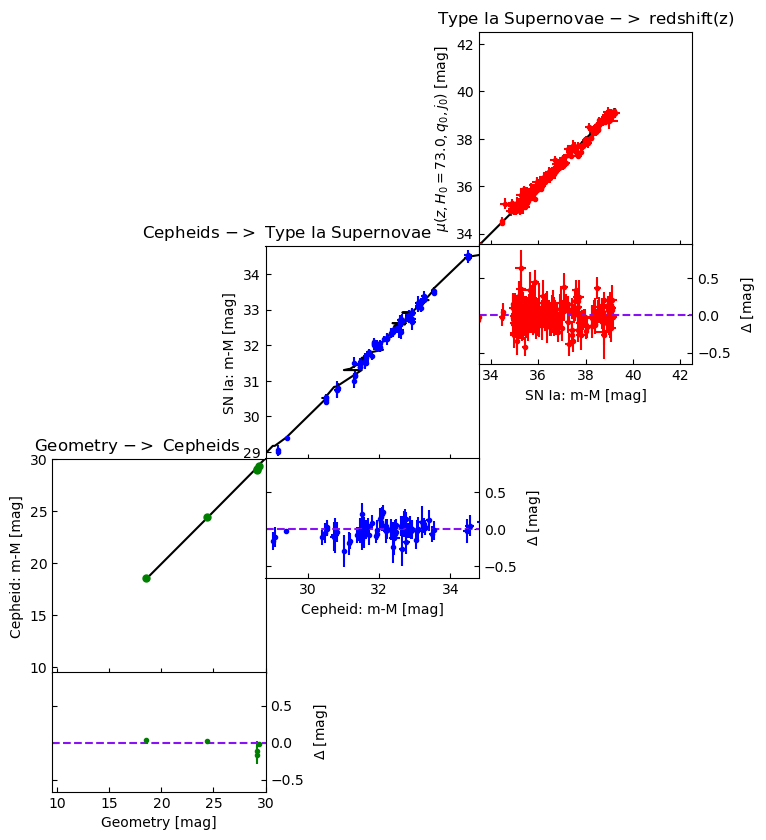

In [611]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, gridspec_kw={'height_ratios': [1.5, 1]})

# Adjusting the subplot parameters to remove space between certain plots
plt.subplots_adjust(hspace=0.0)

# 1st rung
ax1.errorbar(mu_values, mM_values, xerr=mu_errors, yerr=mM_errors, fmt='o', color='g', markersize=5)
ax1.plot(mM_values, mM_pred, color='k')
ax1.set_ylabel(r'Cepheid: m-M [mag]')
ax1.set_ylim(9.5, 30.0)
ax1.set_xlim(9.5, 30.0)
title1 = ax1.set_title(r'Geometry $->$ Cepheids')
title1.set_position([0.4, 1.02]) 

# Residual Plot
ax4.errorbar(mu_values, residuals_all, xerr=mu_errors, yerr=mM_errors, fmt='o', color='g', markersize=3)
ax4.axhline(0, color='#8712F3', linestyle='--')
ax4.set_xlim(9.5, 30.0)
ax4.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax4.set_xlabel(r'Geometry [mag]')

# Adapting labels and ticks
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in')
ax4.tick_params(axis='x', direction='in')
ax4.tick_params(axis='y', direction='in', labelright=True, right=True)

# 2nd rung
ax2.errorbar(mu_values, mM_values, xerr=mu_errors, yerr=mM_errors, fmt='o', color='b', markersize=3)
sorted_indices = np.argsort(mM_pred)
mM_values_sorted = mM_values[sorted_indices]
mM_pred_sorted = mM_pred[sorted_indices]
ax2.plot(mM_values_sorted, mM_pred_sorted, color='k')
ax2.set_ylim(28.8, 34.8)
ax2.set_xlim(28.8, 34.8)
ax2.set_ylabel(r'SN Ia: m-M [mag]')
title2 = ax2.set_title(r'Cepheids $->$ Type Ia Supernovae')
title2.set_position([0.1, 2.04])

# Residual Plot
ax5.errorbar(mM_values, residuals_all, xerr=mu_errors, yerr=mM_errors, fmt='o', color='b', markersize=3)
ax5.axhline(0, color='#8712F3', linestyle='--')
ax5.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax5.set_xlim(28.8, 34.8)
ax5.set_xlabel(r'Cepheid: m-M [mag]')

# Adapting labels and ticks
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
ax2.tick_params(axis='x', direction='in')
ax2.tick_params(axis='y', direction='in')
ax5.tick_params(axis='x', direction='in')
ax5.tick_params(axis='y', direction='in')
ax5.tick_params(axis='y', direction='in', labelright=True, right=True)

# 3rd rung
ax3.errorbar(mu_values, mM_values, xerr=mu_errors, yerr=mM_errors, fmt='o', color='r', markersize=3)
ax3.plot(mu_values, mM_pred, color='k')
ax3.set_ylabel(r'$\mu(z, H_0=73.0, q_0, j_0)$ [mag]')
ax3.set_ylim(33.5, 42.5)
ax3.set_xlim(33.5, 42.5)
ax3.set_title(r'Type Ia Supernovae $->$ redshift(z)')

# Residual Plot
ax6.errorbar(mM_values, residuals_all, xerr=mu_errors, yerr=mu_errors, fmt='o', color='r', markersize=3)
ax6.axhline(0, color='#8712F3', linestyle='--')
ax6.set_ylabel(r'$\Delta$ [mag]', labelpad=-200)
ax6.set_xlim(33.5, 42.5)
ax6.set_xlabel(r'SN Ia: m-M [mag]')

# Adapting labels and ticks
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)
ax3.tick_params(axis='x', direction='in')
ax3.tick_params(axis='y', direction='in')
ax6.tick_params(axis='x', direction='in')
ax6.tick_params(axis='y', direction='in', labelright=True, right=True)
plt.tight_layout()

# Manually adjust the width and position of each plot to occupy 1/3 of the total plot width
def adjust_subplot_position(ax, left, bottom, width, height):
    pos = ax.get_position()
    new_pos = [left, bottom, width, height]
    ax.set_position(new_pos)

# Width for each subplot (1/3 of the total figure width)
subplot_width = 1/3
subplot_height_top = 0.75
subplot_height_bottom = 0.25

# Adjusting positions
adjust_subplot_position(ax1, 0, 0.25, subplot_width, subplot_height_top)
adjust_subplot_position(ax4, 0, 0.155, subplot_width, subplot_height_bottom)
adjust_subplot_position(ax2, subplot_width, -0.055 + 1 * subplot_height_top, subplot_width, subplot_height_top)
adjust_subplot_position(ax5, subplot_width, 0.35 + 1 * subplot_height_bottom, subplot_width, subplot_height_bottom)
adjust_subplot_position(ax3, 2 * subplot_width, 0. + 1.52 * subplot_height_top, subplot_width, subplot_height_top)
adjust_subplot_position(ax6, 2 * subplot_width, 0.545 + 2 * subplot_height_bottom, subplot_width, subplot_height_bottom)

# Set aspect ratio to be equal for the top row
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

# Parameters
coefficient_tot = model.coef_
intercept_tot = model.intercept_

# Print parameters
print(f"Coefficient tot: {coefficient_tot}")
print(f"Intercept tot: {intercept_tot}", 'mag')

plt.show()


Blu part fit gives problems. Actually, I have 77 points VS 42 points of the article. Could the presence of 2 points for x value cause overfitting?